In [37]:
import numpy as np 
import torch 
import garch_framework as frame
from garch_framework.layers.losses import CorrectedNLoss
from garch_framework.utils.helpers import generate_ground_data, save_model_params
from garch_framework.utils.datasets import LSTMGARCHDataset
from garch_framework.models import GARCHLSTM, GJRGARCHModel
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.utils.data import Dataset
from arch import arch_model
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [38]:
omega=0.2
alpha=0.2
gamma= 0.05
beta=0.5

In [39]:
grounds = [omega, alpha, gamma, beta]

In [40]:
data, volat = generate_ground_data(mode = 'GJRGARCH',omega=omega, alpha=alpha, gamma=gamma,beta=beta, n=10000)

In [41]:
volat = np.square(volat)

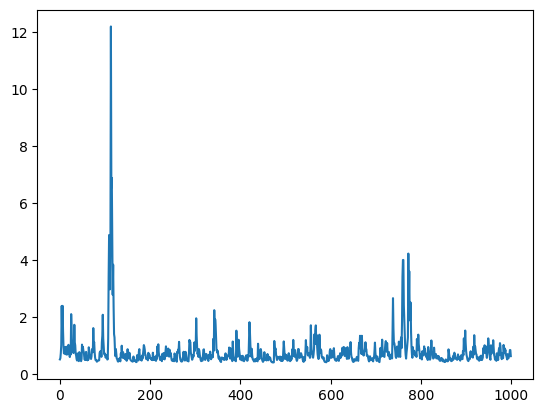

In [42]:
plt.plot(volat[:1000])

In [43]:
train_len = len(data)

In [44]:
train_ds =LSTMGARCHDataset(data[:int(0.8 * train_len)], volat[:int(0.8 * train_len)])

In [45]:
val_ds = LSTMGARCHDataset(data[int(0.8 * train_len):int(0.9 * train_len)], volat[int(0.8 * train_len):int(0.9 * train_len)])

In [46]:
test_ds = LSTMGARCHDataset(data[int(0.9 * train_len):], volat[int(0.9 * train_len):])

In [47]:
train_ds[0]

(tensor(-0.6231), tensor(0.5168), tensor(1.1183))

In [48]:
core = GJRGARCHModel()

In [49]:
train_dl = DataLoader(train_ds, batch_size=8 , shuffle= False, drop_last= False)

In [50]:
val_dl = DataLoader(val_ds, batch_size=8 , shuffle= False, drop_last= False)

In [51]:
test_dl = DataLoader(test_ds, batch_size=8 , shuffle= False, drop_last= False)

In [52]:
criterion = CorrectedNLoss()

In [ ]:

model = GARCHLSTM(garch_core= core, hidden_size=16)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [ ]:

batch_size = 8
hidden_state = None  

num_epochs = 15

for epochs in tqdm(range(num_epochs), desc="Training"):
    epoch_loss =0.0
    model.train()
# В цикле по временным шагам
    for eps, sigma2, eps_true in train_dl:
        optimizer.zero_grad()
        sigma2_pred, hidden_state = model(eps, sigma2, hidden_state)

        loss = criterion(sigma2_pred, eps_true**2)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        hidden_state = hidden_state.detach()
    
    avg_loss = epoch_loss/len(train_dl)


    tqdm.write(f"Epoch {epochs+1}/{num_epochs} | Loss: {avg_loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")
    # hidden_state автоматически передается в следующий шаг

Training:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Loss: 0.3074 | LR: 1.00e-03
Epoch 2/15 | Loss: 0.3030 | LR: 1.00e-03
Epoch 3/15 | Loss: 0.3018 | LR: 1.00e-03
Epoch 4/15 | Loss: 0.3010 | LR: 1.00e-03
Epoch 5/15 | Loss: 0.3004 | LR: 1.00e-03
Epoch 6/15 | Loss: 0.2999 | LR: 1.00e-03
Epoch 7/15 | Loss: 0.2996 | LR: 1.00e-03
Epoch 8/15 | Loss: 0.2994 | LR: 1.00e-03
Epoch 9/15 | Loss: 0.2993 | LR: 1.00e-03
Epoch 10/15 | Loss: 0.2991 | LR: 1.00e-03
Epoch 11/15 | Loss: 0.2991 | LR: 1.00e-03
Epoch 12/15 | Loss: 0.2990 | LR: 1.00e-03
Epoch 13/15 | Loss: 0.2990 | LR: 1.00e-03
Epoch 14/15 | Loss: 0.2989 | LR: 1.00e-03
Epoch 15/15 | Loss: 0.2989 | LR: 1.00e-03


In [69]:
predictions = []
targets = []

model.eval()

with torch.no_grad():
    for eps, sigma2, eps_true in test_dl:
        sigma2_pred, hidden_state = model(eps, sigma2, hidden_state)
        predictions.extend(sigma2_pred.view(-1).tolist())  # исправлено

In [70]:
targets = volat[int(0.9 * train_len)+1:]

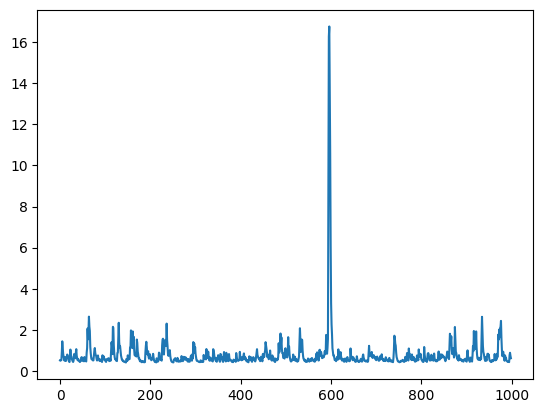

In [71]:
plt.plot(targets)

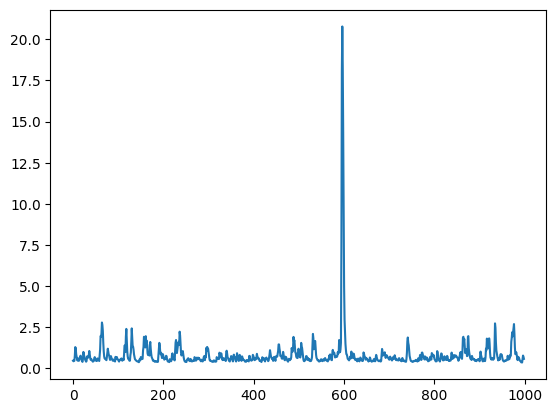

In [72]:
plt.plot(predictions)

In [73]:
targets_eps = data[int(0.9 * train_len)+1:]

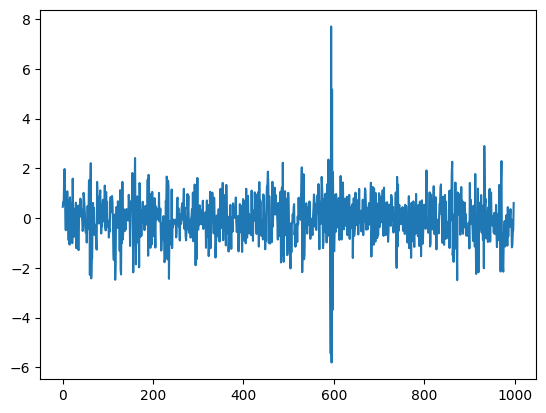

In [74]:
plt.plot(targets_eps)

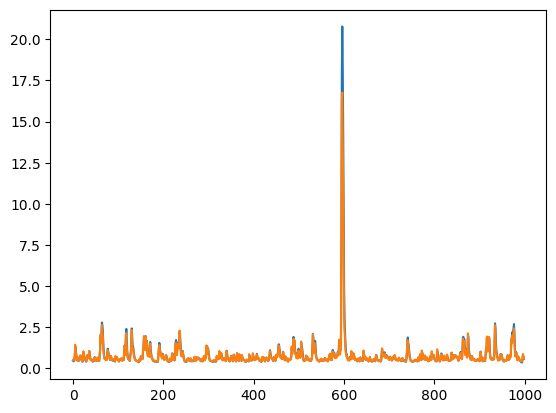

In [75]:
plt.plot(predictions)
plt.plot(targets)

In [78]:
predictions = np.array(predictions)
targets = np.array(targets)

In [80]:
mse_loss = mean_squared_error(predictions, targets)

In [81]:
mse_loss

0.07456572772724589